In [73]:
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
import tensorflow.keras.losses as losses
from tensorflow.keras.models import Model

import numpy as np                       # standard numerical python
from sklearn.model_selection import train_test_split   # used to partition datasets
import math
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')  # if this returns empty enable GPU in collab

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Preparing the Data

To train any model we will need training (and validation) data. In TensorFlow, the best way to do this is by creating an instance of the tf.data.Dataset that contains our data. This tf.data.Dataset object can then be used to train the model during training time. 

Specifically, we want to create this dataset from the numpy datat. So we will start by just loading the data

Now we want to create a data loader from the available datasets. For this we are going to load the data into a TensorFlow object from the NumPy data. 

### Load and Format the Data

In [130]:
# load in the NumPy arrays containing data

# T0 = 0; T1 = 400; STEP = 5 is pretty good
T0 = 50
T1 = 450
STEP = 4

T = math.ceil((T1 - T0) / STEP)

data_dir = "/kaggle/input/wuhxxvaezec89zcmxhjtkhj5tsydfwcbk57nyrzxwv2ebkbiru"
X_test_np = np.load(f"{data_dir}/X_test.npy")[:, :, T0:T1:STEP]
y_test_np = np.load(f"{data_dir}/y_test.npy")
person_test = np.load(f"{data_dir}/person_test.npy").flatten()

X_train_valid_np = np.load(f"{data_dir}/X_train_valid.npy")[:, :, T0:T1:STEP]
y_train_valid_np = np.load(f"{data_dir}/y_train_valid.npy")
person_train_valid = np.load(f"{data_dir}/person_train_valid.npy").flatten()

# X_train_valid_np = X_train_valid_np[person_train_valid == 0]
# y_train_valid_np = y_train_valid_np[person_train_valid == 0]
# X_test_np = X_test_np[person_test == 0]
# y_test_np = y_test_np[person_test == 0]

# rearange input dimensions
# model expects (batch, seq, features) but currently we have (batch, features, seq)

X_train_valid_np = np.transpose(X_train_valid_np, (0, 2, 1))
X_test_np = np.transpose(X_test_np, (0, 2, 1))

print("training data:", X_train_valid_np.shape)
print("testing data:", X_test_np.shape)

training data: (2115, 100, 22)
testing data: (443, 100, 22)


### Assign labels to the data

In [131]:
# re-assign labels to be between 0 and 3
y_train_valid_np[y_train_valid_np==769] = 0  # cue onset left
y_train_valid_np[y_train_valid_np==770] = 1  # cue onset right
y_train_valid_np[y_train_valid_np==771] = 2  # cue onset foot
y_train_valid_np[y_train_valid_np==772] = 3  # cue onset tongue

y_test_np[y_test_np==769] = 0  # cue onset left
y_test_np[y_test_np==770] = 1  # cue onset right
y_test_np[y_test_np==771] = 2  # cue onset foot
y_test_np[y_test_np==772] = 3  # cue onset tongue

### Split the training/validation data

In [132]:
# split the training and validation
from sklearn.model_selection import train_test_split

X_train_np, X_valid_np, y_train_np, y_valid_np = train_test_split(X_train_valid_np, y_train_valid_np, test_size=0.2, random_state=12345)
# X_train_np = np.vstack([X_train_np[:, T0+k:T1+k:STEP, :] for k in range(0, 250, 50)])
# y_train_np = np.hstack([y_train_np for _ in range(0, 250, 50)])
# X_valid_np = X_valid_np[:, T0:T1:STEP, :]

### Create grayscale images for CNN training

In [133]:
# add extra dimension for grayscale images
X_train_np_grayscale = np.expand_dims(X_train_np, axis=-1)
X_valid_np_grayscale = np.expand_dims(X_valid_np, axis=-1)
X_test_np_grayscale = np.expand_dims(X_test_np, axis=-1)

print("training images:", X_train_np_grayscale.shape)
print("training labels:", y_train_np.shape)
print("validation images:", X_valid_np_grayscale.shape)
print("validation labels:", y_valid_np.shape)
print("test images:", X_test_np_grayscale.shape)
print("test labels:", y_test_np.shape)

training images: (1692, 100, 22, 1)
training labels: (1692,)
validation images: (423, 100, 22, 1)
validation labels: (423,)
test images: (443, 100, 22, 1)
test labels: (443,)


### Create tf.data.Dataset objects for the data

for more info see: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [134]:
# construct the dataset from the NumPy arrays
X_train_grayscale = tf.data.Dataset.from_tensor_slices((X_train_np_grayscale, y_train_np))
X_valid_grayscale = tf.data.Dataset.from_tensor_slices((X_valid_np_grayscale, y_valid_np))
X_test_grayscale = tf.data.Dataset.from_tensor_slices((X_test_np_grayscale, y_test_np))

# batch and shuffle
X_train_grayscale = X_train_grayscale.shuffle(1024).batch(64)
X_valid_grayscale = X_valid_grayscale.shuffle(1024).batch(64)
X_test_grayscale = X_test_grayscale.shuffle(1024).batch(64)

In [135]:
# construct the dataset from the NumPy arrays
X_train = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
X_valid = tf.data.Dataset.from_tensor_slices((X_valid_np, y_valid_np))
X_test = tf.data.Dataset.from_tensor_slices((X_test_np, y_test_np))

# batch and shuffle
X_train = X_train.shuffle(1024).batch(64)
X_valid = X_valid.shuffle(1024).batch(64)
X_test = X_test.shuffle(1024).batch(64)

In [136]:
print(X_train)
print(X_valid)
print(X_test)

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Visualize the data

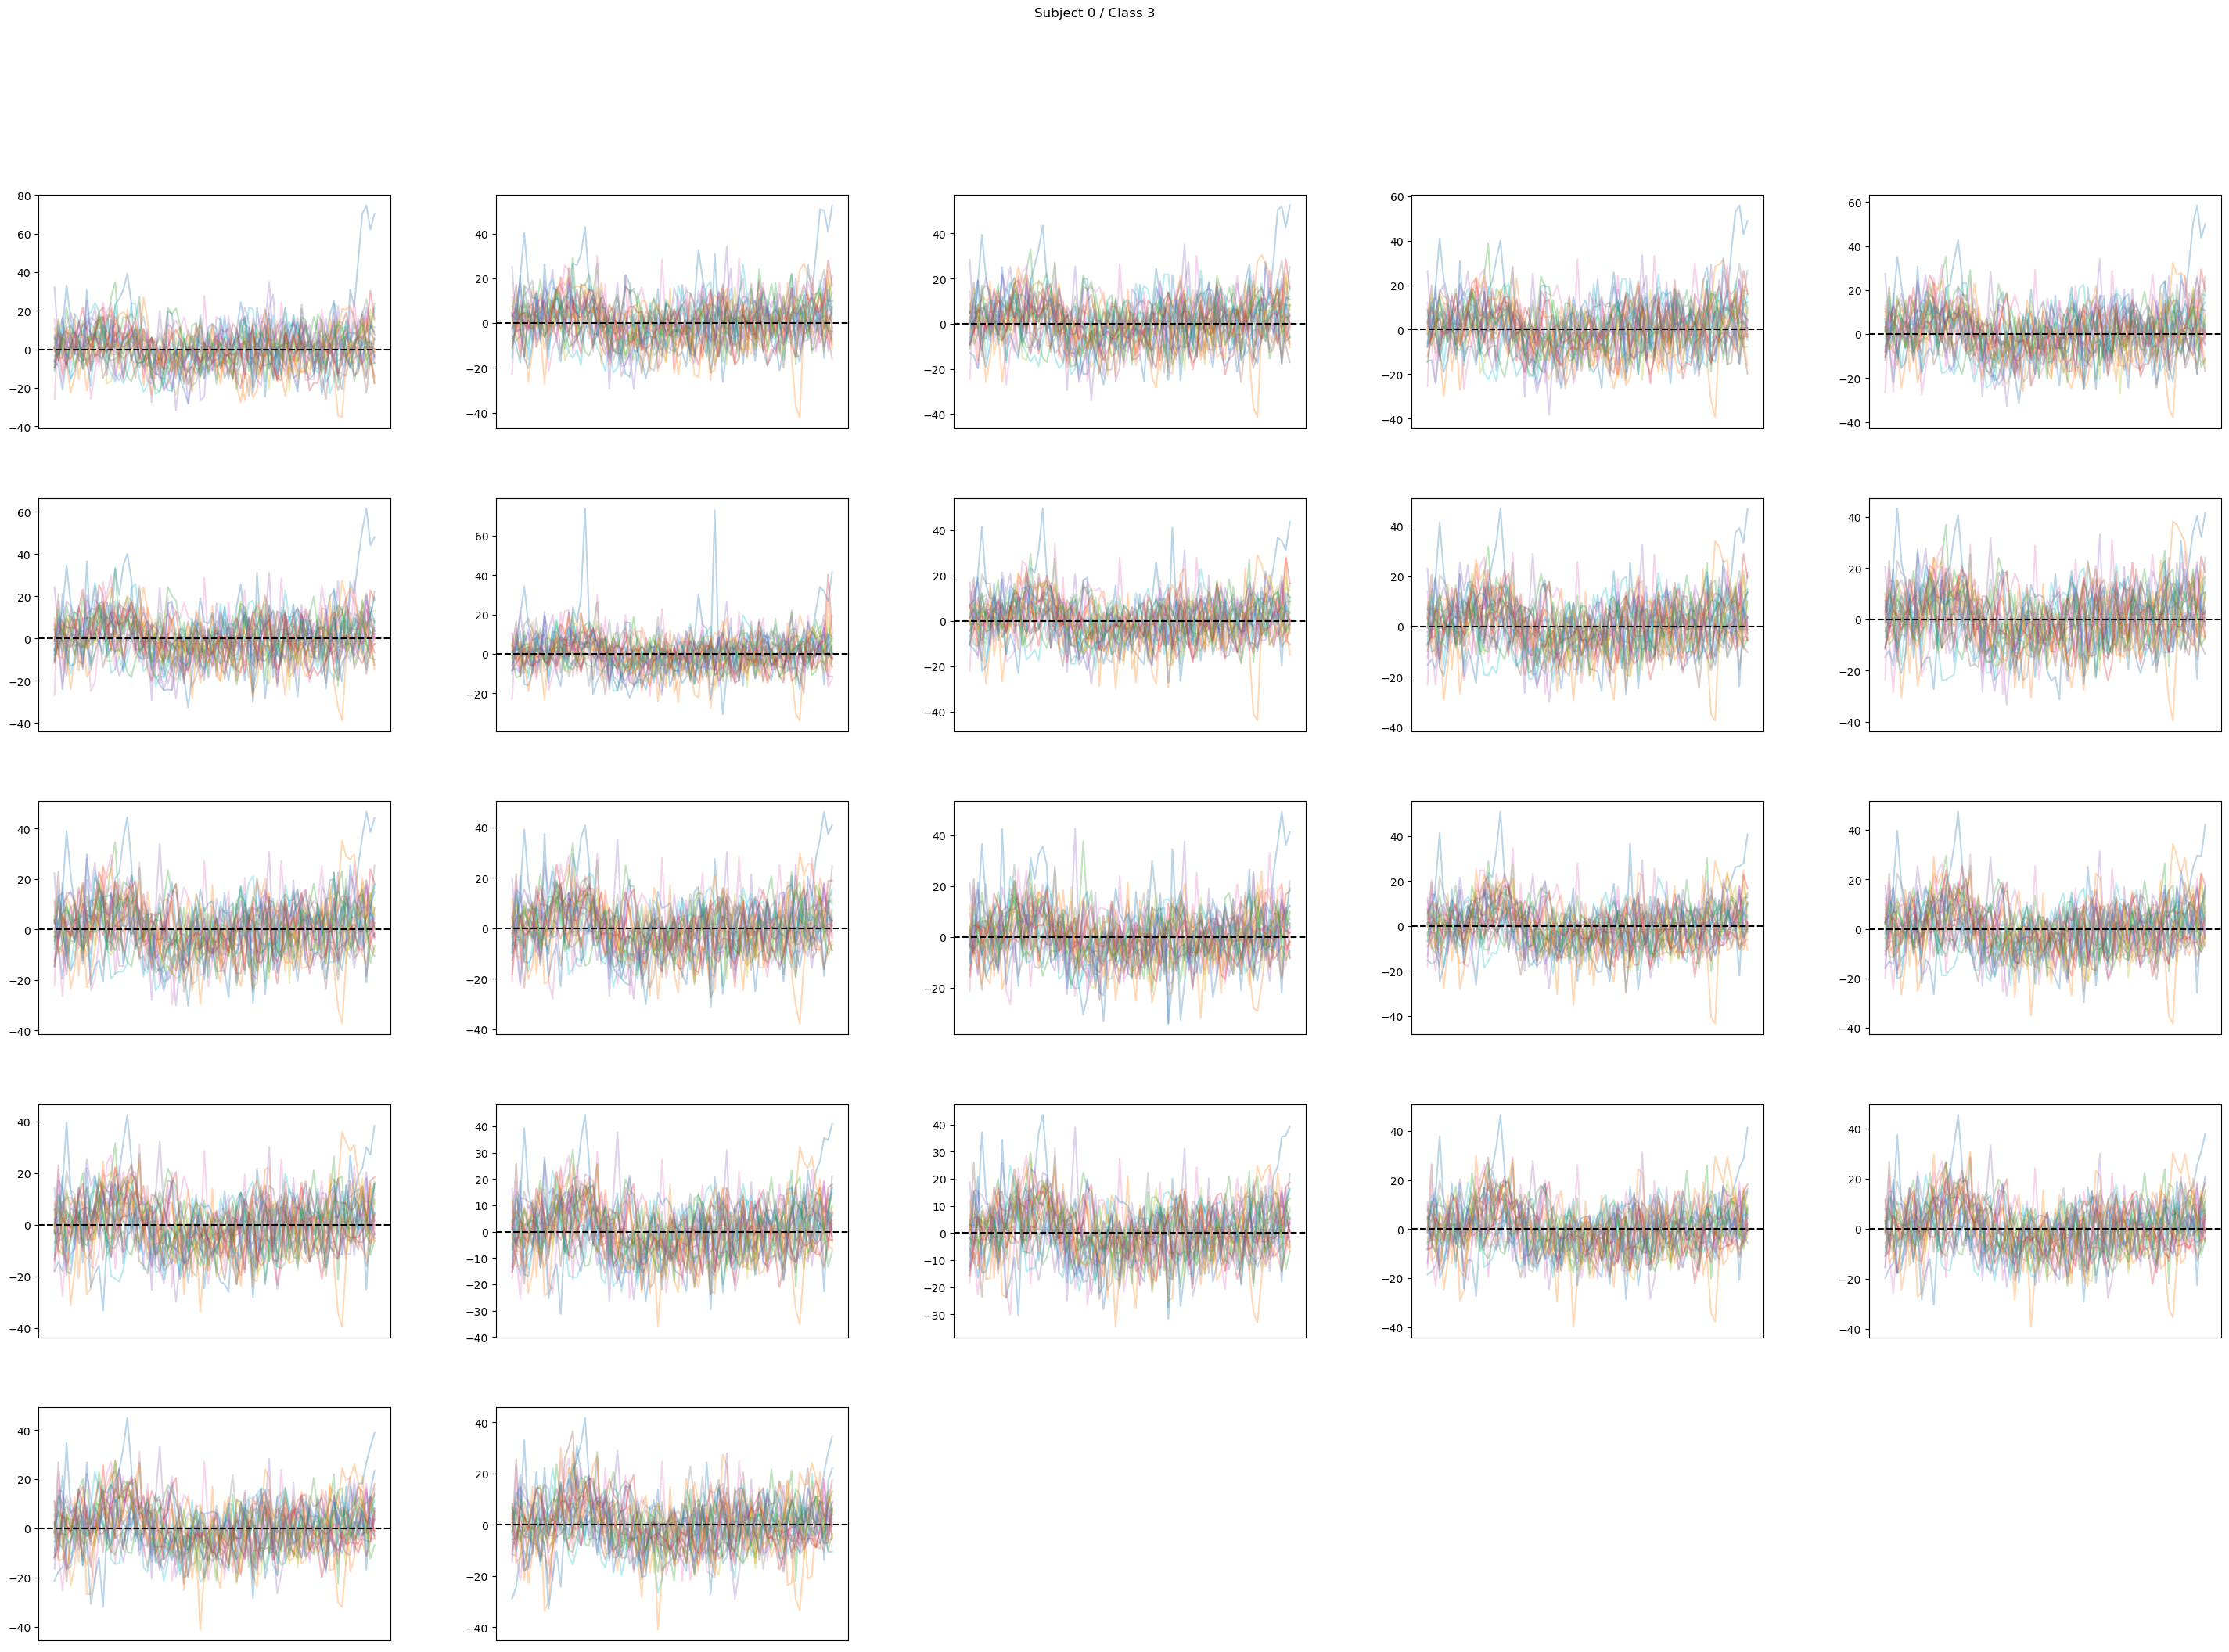

In [10]:
p = 0
c = 3

count = 1
fig = plt.figure(figsize=(36, 24))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
rows, cols = 5, 5

class_data = X_train_valid_np[y_train_valid_np == c]
rand_indices = np.random.choice(len(class_data), size=25, replace=False)

for i in range(22):
    if person_train_valid[i] != p:
        continue

    ax = fig.add_subplot(rows, cols, count)
    for j in rand_indices:
        ax.plot(X_train_valid_np[j,:,i], alpha=0.3)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.axhline(0, linestyle='--', c='black')
    count += 1

fig.suptitle(f'Subject {p} / Class {c}')
plt.show()

# Creating A Convolutional Neural Network Model in TensorFlow

In [62]:
# using the built in sparse categorical cross entropy loss
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# choose an optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)
# there are some other optimizers you can choose from
#opt = keras.optimizers.Adamax()
#opt = keras.optimizers.RMSprop()
#opt = keras.optimizers.SGD()

In [ ]:
cnn_clf = tf.keras.Sequential([
    keras.layers.Conv2D(6, (50,1), strides=(25,1), input_shape=(T,22,1), name="conv1"),
    keras.layers.Conv2D(6, (1, 4), strides=(1,2)),
    keras.layers.AveragePooling2D(pool_size=(10,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(32),
    keras.layers.Dense(4, activation=nn.softmax, name="class-probs")
])

cnn_clf.compile(optimizer=opt, loss=loss_fn, metrics='accuracy')
cnn_clf.summary()

In [66]:
cnn_clf.fit(x=X_train_grayscale, validation_data=X_valid_grayscale, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 0s 16ms/step - loss: 1.2967 - accuracy: 0.3915 - val_loss: 1.7642 - val_accuracy: 0.1667
Epoch 2/1000
3/3 [==============================] - 0s 21ms/step - loss: 1.2767 - accuracy: 0.4127 - val_loss: 1.7495 - val_accuracy: 0.1875
Epoch 3/1000
3/3 [==============================] - 0s 17ms/step - loss: 1.2588 - accuracy: 0.4233 - val_loss: 1.7346 - val_accuracy: 0.1875
Epoch 4/1000
3/3 [==============================] - 0s 16ms/step - loss: 1.2432 - accuracy: 0.4444 - val_loss: 1.7216 - val_accuracy: 0.2083
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 1.2272 - accuracy: 0.4709 - val_loss: 1.7102 - val_accuracy: 0.2083
Epoch 6/1000
3/3 [==============================] - 0s 16ms/step - loss: 1.2140 - accuracy: 0.4709 - val_loss: 1.6975 - val_accuracy: 0.2083
Epoch 7/1000
3/3 [==============================] - 0s 16ms/step - loss: 1.1996 - accuracy: 0.4709 - val_loss: 1.6902 - val_accuracy: 0.2083
Epoch 8/1000


KeyboardInterrupt: 

# Creating A Recurrent Neural Network Model

In [154]:
# rnn_clf = keras.Sequential([
#     layers.LSTM(32, return_sequences=True, input_shape=(T, 22),
#                 dropout=0.2, name="LSTM-1"),
#     layers.LSTM(16, dropout=0.2, name="LSTM-2"),
#     layers.Dense(8, activation=nn.elu),
#     layers.Dense(4, activation=nn.softmax, name="class-probs")
# ])

# Adapted from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9028677/
rnn_clf =  keras.Sequential([
    layers.Input((T, 22)),
    layers.Dense(128, activation="relu", name='linear'),
    layers.Conv1D(64, kernel_size=3, activation="relu", name="conv"),
    layers.MaxPool1D(2),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, name="lstm-1")),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False, name="lstm-2")),
    layers.Dropout(0.4),
    layers.Dense(4, activation=nn.softmax, name="class-probs")
])

loss_fn = keras.losses.SparseCategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-4)

rnn_clf.compile(optimizer=opt, loss=loss_fn, metrics='accuracy')
rnn_clf.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear (Dense)              (None, 100, 128)          2944      
                                                                 
 conv (Conv1D)               (None, 98, 64)            24640     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 49, 64)           0         
 g1D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 49, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 49, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)             

In [155]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=50,
    restore_best_weights=True
)
history = rnn_clf.fit(x=X_train, validation_data=X_valid, epochs=250,
                      callbacks=[early_stop])

Epoch 1/250
27/27 [==============================] - 10s 83ms/step - loss: 1.4064 - accuracy: 0.2654 - val_loss: 1.3849 - val_accuracy: 0.2719
Epoch 2/250
27/27 [==============================] - 1s 20ms/step - loss: 1.3866 - accuracy: 0.2683 - val_loss: 1.3613 - val_accuracy: 0.3475
Epoch 3/250
27/27 [==============================] - 1s 19ms/step - loss: 1.3637 - accuracy: 0.3038 - val_loss: 1.3465 - val_accuracy: 0.3522
Epoch 4/250
27/27 [==============================] - 1s 20ms/step - loss: 1.3502 - accuracy: 0.3322 - val_loss: 1.3325 - val_accuracy: 0.3593
Epoch 5/250
27/27 [==============================] - 1s 31ms/step - loss: 1.3452 - accuracy: 0.3440 - val_loss: 1.3260 - val_accuracy: 0.3806
Epoch 6/250
27/27 [==============================] - 1s 20ms/step - loss: 1.3217 - accuracy: 0.3469 - val_loss: 1.3208 - val_accuracy: 0.3735
Epoch 7/250
27/27 [==============================] - 1s 21ms/step - loss: 1.3231 - accuracy: 0.3647 - val_loss: 1.3086 - val_accuracy: 0.3901
Epoch

In [157]:
rnn_clf.evaluate(X_valid)

7/7 [==============================] - 0s 10ms/step - loss: 1.4262 - accuracy: 0.6667


[1.4261739253997803, 0.6666666865348816]

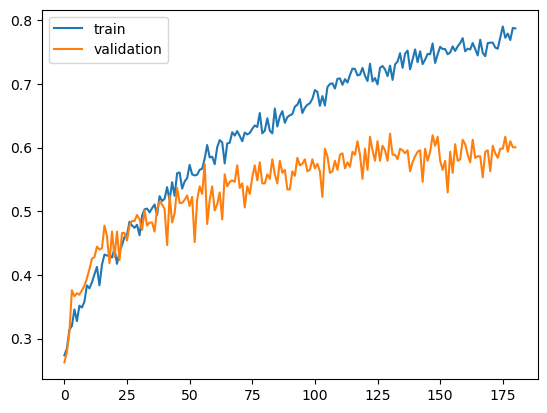

In [148]:
plt.plot(np.arange(len(history.history['accuracy'])), history.history['accuracy'], label='train')
plt.plot(np.arange(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()